# Natural diversity

Compare mutational data against existing PB1 diversity, as well as generate sequence logos for regions of interst for the sake of looking how different bases impact fitness.

PB1 sequences from NCBI flu database (https://www.ncbi.nlm.nih.gov/genomes/FLU/Database/nph-select.cgi?go=database)
    Jul 25 2024

Parameters were to exclude lab strains, exclude vaccine strains, only full-length, only sequences of 2341 in length.

CD-HIT-est was then used to cluster anything with 99% identity to attempt to reduce over-represented sequences. 

Removed any sequences with ambiguous characters.

Manually curated to remove clear indels, as sequences should align with no effort.

This results in 1939 high-quality PB1 sequences. I did not restrict based on host, which could produce some disagreement with data.

In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
scripts = 'Scripts'
sys.path.append(scripts)
import mutCalling
import scipy
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import dmslogo
from statsmodels.stats import multitest
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

In [36]:
import importlib
importlib.reload(mutCalling)
PB1align = 'Database/reducedFluPB1.fa'
if not os.path.isdir('Results'):
    os.mkdir('Results')
if not os.path.isdir('Results/naturalAnalysis'):
    os.mkdir('Results/naturalAnalysis')
mutCalling.fastaReport(inFasta=PB1align, outfile='Results/naturalAnalysis/PB1natural.tsv')

In [37]:
def reverseComplementDataframe(inframe):
    maxpos = inframe['position'].max()
    modFrame = inframe.copy()
    modFrame['realpos'] = abs(maxpos - modFrame['position']) + 1
    outframe = pd.DataFrame()
    outframe['position'] = modFrame['realpos']
    outframe['A'] = modFrame['T']
    outframe['T'] = modFrame['A']
    outframe['C'] = modFrame['G']
    outframe['G'] = modFrame['C']
    return outframe

data = reverseComplementDataframe(pd.read_csv('Results/naturalAnalysis/PB1natural.tsv', sep='\t'))

data['majorityVariant'] = data[['A','G','C','T']].idxmax(axis=1)
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)
def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  1 - (row[column]/row.totalDepth)
    else:
        return 0
data['minorityFreq'] = data.apply(lambda row: minorityVariant(row), axis=1)

Call as binary. Where to set threshold? Lets do a rarefaction analysis.

In [38]:
currFrac = 0.0001
step = 0.0001
graph = []
totalsites = len(data)
while currFrac <= 0.75:
    totals = len(data.loc[data.minorityFreq>= currFrac])/totalsites
    graph += [pd.DataFrame({'variable_cutoff':[currFrac], 'fraction of sites':[totals]})]
    currFrac += step
graph = pd.concat(graph)
    

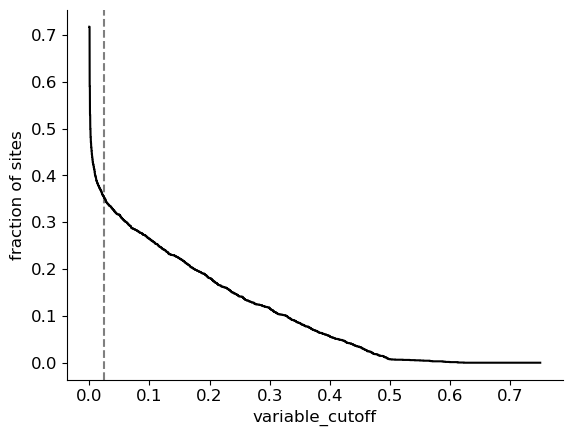

In [39]:
sns.lineplot(data=graph, x='variable_cutoff', y='fraction of sites', color='k')
plt.axvline(0.025, ls = '--', alpha =0.5, color = 'k')
sns.despine()
plt.savefig('Figures/variantCutoff.pdf', format='pdf', bbox_inches = "tight")


In [40]:
data['category'] = 'CDS'
data.loc[data['position'] <= 13, 'category'] = 'U13'
data.loc[data['position'] >= (data['position'].max() - 12), 'category'] = 'U12'
data.loc[(data['position'] <= 125) & (data['position'] >= 75), 'category'] = 'del1'
data.loc[(data['position'] <= 2192) & (data['position'] >= 2116), 'category'] = 'del2'
data.loc[(data['position'] <= 43) & (data['position'] >= 14), 'category'] = '5UTR'
data.loc[(data['position'] <= 2329) & (data['position'] >= 2318), 'category'] = '3UTR'
data['variable'] = data.minorityFreq > 0.025

In [41]:
graph = data.loc[data.category.isin(['del1','CDS']),]
graph['del1'] = graph.category == 'del1'

/tmp/ipykernel_3918634/2539276962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['del1'] = graph.category == 'del1'


The null hypothesis is rejected at a pvalue of 0.004914743692407157


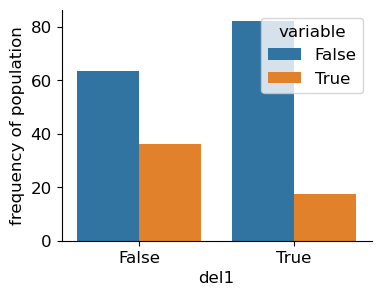

In [42]:
fig,ax = plt.subplots(1,1, figsize=(4,3))

contingency = pd.crosstab(graph.del1, graph.variable)
ratio, pval = scipy.stats.fisher_exact(contingency)
frequency = pd.crosstab(graph.del1, graph.variable, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'del1', y='value', hue='variable', data=frequency, ax = ax)
sns.despine()
ax.set_ylabel('frequency of population')

if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/variationNatDivdel1vsCDS.pdf', format='pdf', bbox_inches = "tight")

In [43]:
graph = data.loc[data.category.isin(['del1','del2']),]
graph['del1'] = graph.category == 'del1'

/tmp/ipykernel_3918634/4277197187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['del1'] = graph.category == 'del1'


The null hypothesis is rejected at a pvalue of 0.011277504702618298


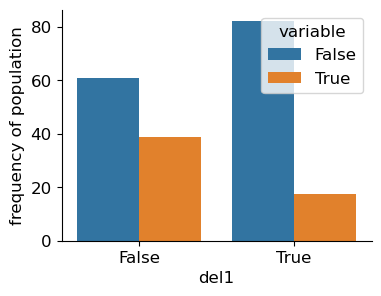

In [44]:
fig,ax = plt.subplots(1,1, figsize=(4,3))

contingency = pd.crosstab(graph.del1, graph.variable)
ratio, pval = scipy.stats.fisher_exact(contingency)
frequency = pd.crosstab(graph.del1, graph.variable, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'del1', y='value', hue='variable', data=frequency, ax = ax)
sns.despine()
ax.set_ylabel('frequency of population')

if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/variationNatDivdel1vsdel2.pdf', format='pdf', bbox_inches = "tight")

In [45]:
dataFolder = 'Results/SNPcounts'

#adjust coordinates for adapters
posAdjustAmplicon = 14
posAdjustRACE = 30
PB1delLength = 562

posAdjustRACEplas = 56


In [46]:
data = []
for file in glob.glob('Results/SNPcounts/*.tsv'):
    baseName = os.path.basename(file)
    if baseName.split('_')[0] == 'RACE':
        currData = pd.read_csv(file, sep = '\t')
        currData['category'] = baseName.split('-')[0].split('_')[1]
        currData['replicate'] = baseName.split('-')[1][0]
        if baseName.split('-')[0].split('_')[1] != 'plas':
            currData['position'] = currData['position']-posAdjustRACE
        else:
            currData['position'] = currData['position']-posAdjustRACEplas
        currData['sequencing'] = 'RACE'
        #only use to infer to first and last 20 nt
        currData = currData[(currData['position'] <= 20) | (currData['position'] > PB1delLength - 20)]
        data += [currData]

    else:
        currData = pd.read_csv(file, sep = '\t')
        currData['category'] = baseName.split('-')[0]
        currData['replicate'] = baseName.split('-')[1][0]
        currData['position'] = currData['position']-posAdjustAmplicon
        currData['sequencing'] = 'amplicon'
        #exclude first and last 20 nt
        currData = currData[(currData['position'] > 20) & (currData['position'] <=PB1delLength - 20)]
        data += [currData]
data = pd.concat(data)
data = data.loc[(data.position > 0) & (data.position <= PB1delLength)]

In [47]:
data['majorityVariant'] = data[['A','G','C','T']].idxmax(axis=1)
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)
def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  1 - (row[column]/row.totalDepth)
    else:
        return 0
plasmid = data.loc[(data.category == 'plas'),]
data['minorityFreq'] = data.apply(lambda row: minorityVariant(row), axis=1)

In [48]:
allPoints = data.pivot_table(index=['position', 'replicate'], columns='category', values='minorityFreq').reset_index()
allPoints['difference'] = np.log2(allPoints.withNEP/allPoints.noNEP)
allPoints['pval_difference'] = allPoints.apply(lambda row: stats.ttest_1samp(allPoints[allPoints.position == row.position].difference, popmean=0)[1], axis =1 )

allPoints['mg'] = np.log2(allPoints.noNEP/allPoints.plas)
allPoints['pval_mg'] = allPoints.apply(lambda row: stats.ttest_1samp(allPoints[allPoints.position == row.position].mg, popmean=0)[1], axis =1 )

allPoints['NS2'] = np.log2(allPoints.withNEP/allPoints.plas)
allPoints['pval_NS2'] = allPoints.apply(lambda row: stats.ttest_1samp(allPoints[allPoints.position == row.position].NS2, popmean=0)[1], axis =1 )


PB1length = 2341
allPoints['context'] = 'CDS'
allPoints.loc[allPoints.position <= 24, 'context'] = '3\' UTR'
allPoints.loc[allPoints.position <= 12, 'context'] = 'U12'
allPoints.loc[allPoints.position >= 519, 'context'] = '5\' UTR'
allPoints.loc[(allPoints.position >= 542) & (allPoints.position <= 547), 'context'] = 'polyA'

allPoints.loc[allPoints.position >= 550, 'context'] = 'U13'
#fix position in positive then invert
junctionLastBase = 385
otherSideExclude = 2164

allPoints['FullLengthPos'] = allPoints.position
allPoints.loc[allPoints.position > 385, 'FullLengthPos'] = allPoints.loc[allPoints.position > 385].FullLengthPos + otherSideExclude -junctionLastBase 
#now invert
allPoints['FullLengthPos'] = PB1length - allPoints.FullLengthPos + 1


#combine measurements for appropriate qval and some graphing
freqCompare = allPoints[['FullLengthPos',
 'NS2',
 'context',
 'difference',
 'mg',
 'position',
 'pval_NS2',
 'pval_difference',
 'pval_mg',]].groupby(['FullLengthPos','context']).mean().reset_index()


freqCompare['qval_difference'] =  multitest.multipletests(freqCompare.pval_difference, alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
freqCompare['significant_difference'] = (freqCompare.qval_difference < 0.1) & (abs(freqCompare.difference) >= 1)

freqCompare['qval_mg'] =  multitest.multipletests(freqCompare.pval_mg, alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
freqCompare['significant_mg'] = freqCompare.qval_mg < 0.1

freqCompare['qval_NS2'] =  multitest.multipletests(freqCompare.pval_NS2, alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
freqCompare['significant_NS2'] = freqCompare.qval_NS2 < 0.1

In [49]:
NS2responsive = freqCompare[freqCompare.significant_difference].FullLengthPos

In [50]:
NS2responsive

14       15
15       16
17       18
19       20
20       21
21       22
22       23
27       28
54       55
55       56
70       71
71       72
81       82
82       83
90       91
539    2319
540    2320
541    2321
542    2322
543    2323
545    2325
546    2326
547    2327
548    2328
555    2335
559    2339
560    2340
Name: FullLengthPos, dtype: int64

In [51]:
def reverseComplementDataframe(inframe):
    maxpos = inframe['position'].max()
    modFrame = inframe.copy()
    modFrame['realpos'] = abs(maxpos - modFrame['position']) + 1
    outframe = pd.DataFrame()
    outframe['position'] = modFrame['realpos']
    outframe['A'] = modFrame['T']
    outframe['T'] = modFrame['A']
    outframe['C'] = modFrame['G']
    outframe['G'] = modFrame['C']
    return outframe

data = reverseComplementDataframe(pd.read_csv('Results/naturalAnalysis/PB1natural.tsv', sep='\t'))

data['majorityVariant'] = data[['A','G','C','T']].idxmax(axis=1)
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)
def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  1 - (row[column]/row.totalDepth)
    else:
        return 0
data['minorityFreq'] = data.apply(lambda row: minorityVariant(row), axis=1)

In [52]:
data['category'] = data['position'].isin(NS2responsive)
data['variable'] = data.minorityFreq > 0.025

The null hypothesis is rejected at a pvalue of 1.4341078095462772e-05


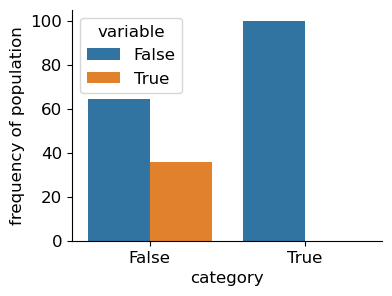

In [53]:
fig,ax = plt.subplots(1,1, figsize=(4,3))

contingency = pd.crosstab(data.category, data.variable)
ratio, pval = scipy.stats.fisher_exact(contingency)
frequency = pd.crosstab(data.category, data.variable, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'category', y='value', hue='variable', data=frequency, ax = ax)
sns.despine()
ax.set_ylabel('frequency of population')

if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/variationNS2respvsall.pdf', format='pdf', bbox_inches = "tight")

Time for logo plot I guess.

Use preferences to infer frequency (ie start at 0.25 for each nucleotide, and scale by selection)

total height of column is log2(4)  - Hi  + en) Hi is shannon entropy
        =entropy will be the sum of frequencies multiplied by log2 of frequencies
        =add in En, which for nucleotides is 1/ln2 x (s-1)/2n, where s is 4, and n will be number of sequences in alignment. (vanishingly small number in this case)

In [32]:
data = []
for file in glob.glob('Results/SNPcounts/*.tsv'):
    baseName = os.path.basename(file)
    if baseName.split('_')[0] == 'RACE':
        currData = pd.read_csv(file, sep = '\t')
        currData['category'] = baseName.split('-')[0].split('_')[1]
        currData['replicate'] = baseName.split('-')[1][0]
        if baseName.split('-')[0].split('_')[1] != 'plas':
            currData['position'] = currData['position']-posAdjustRACE
        else:
            currData['position'] = currData['position']-posAdjustRACEplas
        currData['sequencing'] = 'RACE'
        #only use to infer to first and last 20 nt
        currData = currData[(currData['position'] <= 20) | (currData['position'] > PB1delLength - 20)]
        data += [currData]

    else:
        currData = pd.read_csv(file, sep = '\t')
        currData['category'] = baseName.split('-')[0]
        currData['replicate'] = baseName.split('-')[1][0]
        currData['position'] = currData['position']-posAdjustAmplicon
        currData['sequencing'] = 'amplicon'
        #exclude first and last 20 nt
        currData = currData[(currData['position'] > 20) & (currData['position'] <=PB1delLength - 20)]
        data += [currData]
data = pd.concat(data)
data = data.loc[(data.position > 0) & (data.position <= PB1delLength)]

In [23]:
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)
data['A'] = data.A/data.totalDepth
data['G'] = data.G/data.totalDepth
data['C'] = data.C/data.totalDepth
data['T'] = data['T']/data.totalDepth


In [24]:
allPoints = data.pivot_table(index=['position', 'replicate'], columns='category', values=['A','G','C','T']).reset_index()



In [25]:
#reverse complement here too
categories = {'NS2_specific':('withNEP','noNEP'), 'NS2_mg':('withNEP','plas'),'Mg':('noNEP','plas')}
basesRC = [('A','U'),('G','C'),('C','G'),('T','A')]
for category in categories:
    numerator = categories[category][0]
    denominator = categories[category][1]
    for baseRC in basesRC:
        if allPoints[baseRC[0]][denominator].iloc[0] != 0:
            allPoints[category + '_' + baseRC[1]] = allPoints[baseRC[0]][numerator]/allPoints[baseRC[0]][denominator]
        else:
            allPoints[category + '_' + baseRC[1]] = 0
allPoints.replace([np.inf, -np.inf],0, inplace=True)


In [26]:
graph = allPoints.drop(columns=['replicate']).groupby(['position']).mean().reset_index()




/tmp/ipykernel_3918634/201082766.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  graph = allPoints.drop(columns=['replicate']).groupby(['position']).mean().reset_index()


Convert to frequencies